In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from glob import glob
import seaborn as sns

import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import random
from termcolor import colored
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split
from tsne import bh_sne
import matplotlib.patches as patches
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

# Application

## Predict tissue type in region of interest

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classes = ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
tissue_types = [i.split('_')[1] for i in classes]
print(tissue_types)

['TUMOR', 'STROMA', 'COMPLEX', 'LYMPHO', 'DEBRIS', 'MUCOSA', 'ADIPOSE', 'EMPTY']


In [5]:
inception_fc2 = models.inception_v3(pretrained=True)
inception_fc2.fc = nn.Sequential(nn.Linear(inception_fc2.fc.in_features, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 8))
inception_fc2.AuxLogits.fc = nn.Sequential(nn.Linear(inception_fc2.AuxLogits.fc.in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, 8))
if device.type == 'cpu':
    state_dict = torch.load('models/Colorectal_histology_inception_epoch50_lr4_fc2.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Colorectal_histology_inception_epoch50_lr4_fc2.pth')
inception_fc2.load_state_dict(state_dict)
for param in inception_fc2.parameters():
    param.requires_grad=False

## Tissue segmentation and multi-channel visualization

In [15]:
def histology_cls2(img_path, resolution, model, tissue_types, device):
    model.to(device)
    img = readImage_rgb(img_path)
    
    img_transforms = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    dt = np.dtype(int)
    pred_label = np.array([], dtype = dt)
    top_prob_array = np.array([])
    probs_array = np.array(tissue_types).reshape(1,-1)
    
    for i in np.arange(75, 5000-75, resolution):
        for j in np.arange(75, 5000-75, resolution):
            loc = (j,i)
            img_crop = img[loc[0]-75:loc[0]+75,loc[1]-75:loc[1]+75,:] 
            img_pil = Image.fromarray(img_crop.astype('uint8'), 'RGB')
            input_img = torch.unsqueeze(img_transforms(img_pil).to(device), dim=0)
            with torch.no_grad():
                model.eval()
                output = model(input_img)
                softmax = nn.Softmax(dim=1)
                output_softmax = softmax(output)
                top_prob, pred = output_softmax.topk(1,dim=1)
                top_prob, pred = top_prob.cpu().item(), pred.cpu().item()
                probs = output_softmax.cpu()
                pred_label = np.append(pred_label, pred)
                top_prob_array = np.append(top_prob_array, top_prob)
                probs_array = np.concatenate((probs_array, probs))
    pred_df = pd.DataFrame({'pred': pred_label, 'prob': top_prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = probs_array[0])
    return pred_df, probs_df

In [16]:
img_paths = glob('/Volumes/Yuchen_Drive/Colorectal_histology_mnist/Kather_texture_2016_larger_images_10/*.tif')

In [ ]:
pred_df, probs_df = histology_cls2(img_paths[0], 50, inception_fc2, tissue_types, device)

The segmentation is performed for all 10 images at 3 different resolutions in cluster. The prediction result is visualized together with the raw image. 

### Image2

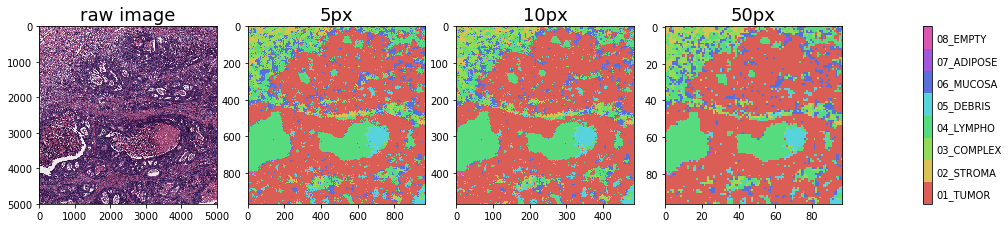

In [20]:
pred_dfs = ['application/img2_5px_pred_df.csv','application/img2_10px_pred_df.csv','application/img2_50px_pred_df.csv']
plot_prediction(img_paths[1], pred_dfs)

### Image5

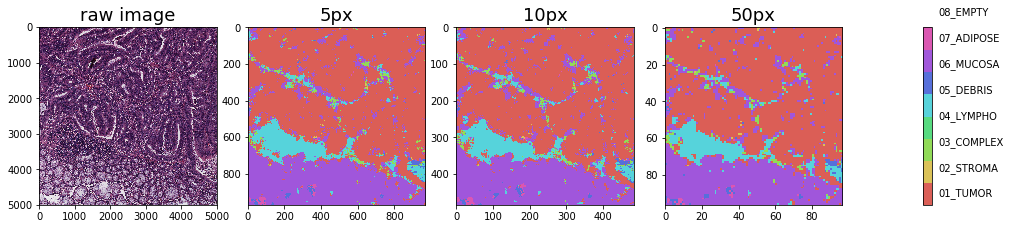

In [23]:
pred_dfs = ['application/img5_5px_pred_df.csv','application/img5_10px_pred_df.csv','application/img5_50px_pred_df.csv']
plot_prediction(img_paths[4], pred_dfs)

### Image6

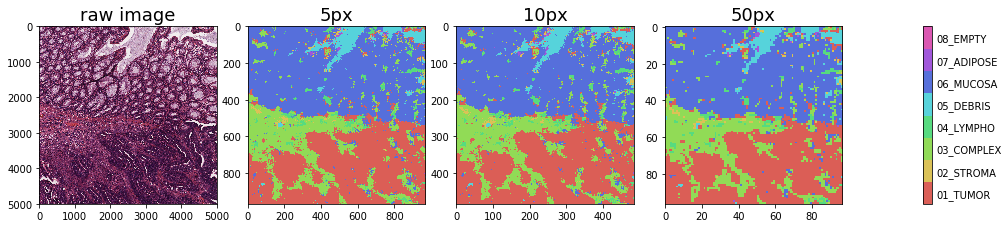

In [24]:
pred_dfs = ['application/img6_5px_pred_df.csv','application/img6_10px_pred_df.csv','application/img6_50px_pred_df.csv']
plot_prediction(img_paths[5], pred_dfs)

For each tissue type, we can also plot the prediction confidence or class probabilities.

In [30]:
## https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
def plot_prob(img_path, pred_path, prob_path, resolution, tissue):
    resolution_dict = {'5px':970, '10px':485, '50px':97}
    #resolution_list = ['5px', '10px', '50px']
    #pixel_list = [970, 485, 97]
    palette = sns.color_palette('hls', 8)
    cmap = ListedColormap(palette)
    img = readImage_rgb(img_path)
    fig = plt.figure(figsize=(16,4))
    gs = GridSpec(1, 5, width_ratios=[3,3,3,1,1]) 
    #gs=GridSpec(2,3)
    ax = fig.add_subplot(gs[0])
    plt.imshow(img)
    ax.set_title('raw image', fontsize=18)
    
    img_size = resolution_dict[resolution]
    pred_df = pd.read_csv(pred_path)
    preds = pred_df['pred']
    ax = fig.add_subplot(gs[1])
    ax.set_title('pred_{}'.format(resolution), fontsize=18)
    heatmap = plt.imshow(np.array(preds).reshape(img_size,img_size), cmap = cmap)
    ax = fig.add_subplot(gs[3], xticks=[], yticks=[])
    ax.axis('off')
    cbar = plt.colorbar(heatmap)
    cbar.ax.get_yaxis().set_ticks([])
    for i,v in enumerate(classes):
        cbar.ax.text(10, (7 * i + 3) / 8.0, v, ha='left', va='center')  
    
    prob_df = pd.read_csv(prob_path)
    probs = prob_df[tissue]
    ax = fig.add_subplot(gs[2])
    ax.set_title('prob for {}'.format(tissue), fontsize=18)
    heatmap2 = plt.imshow(np.array(probs).reshape(img_size,img_size), cmap = 'hot')
    ax = fig.add_subplot(gs[4], xticks=[], yticks=[])
    ax.axis('off')
    cbar = plt.colorbar(heatmap2)

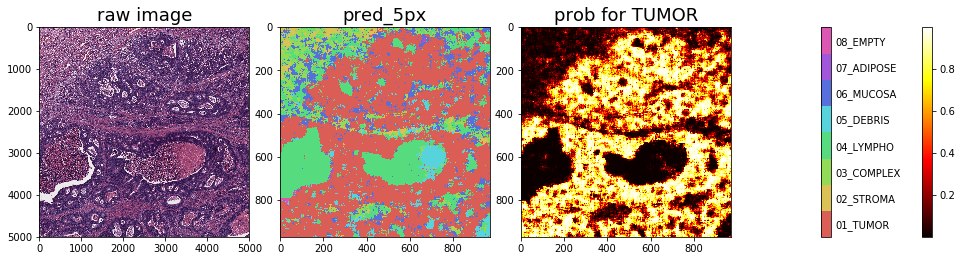

In [32]:
pred_df_path = 'application/img2_5px_pred_df.csv'
prob_df_path = 'application/img2_5px_probs_df.csv'
plot_prob(img_path=img_paths[1], pred_path=pred_df_path, prob_path=prob_df_path, resolution='5px', tissue='TUMOR')

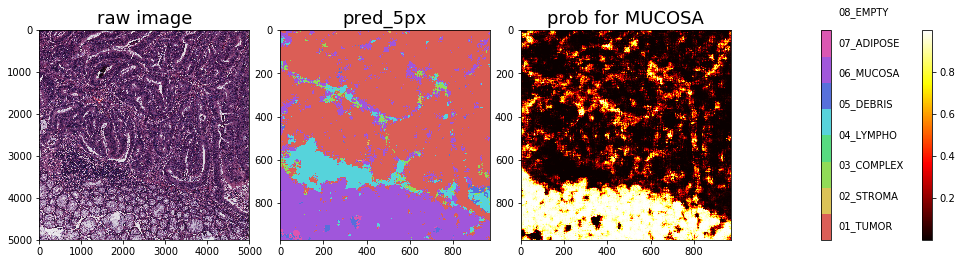

In [35]:
pred_df_path = 'application/img5_5px_pred_df.csv'
prob_df_path = 'application/img5_5px_probs_df.csv'
plot_prob(img_path=img_paths[4], pred_path=pred_df_path, prob_path=prob_df_path, resolution='5px', tissue='MUCOSA')